In [21]:
import os
import json
import pickle
from collections import Counter
import re

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf

import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Dense, Lambda, LSTM
from keras.layers.pooling import _GlobalPooling1D, GlobalAveragePooling1D
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import get_file

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

In [2]:
sns.set(style="whitegrid", font_scale=1.3)

matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["legend.fontsize"] = 14

matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["font.size"] = 14

matplotlib.rcParams["xtick.labelsize"] = 14
matplotlib.rcParams["ytick.labelsize"] = 14

matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 20

In [3]:
np.random.seed(42)

In [4]:
with open("../data/conversations.txt") as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [5]:
questions = []
answers = []

In [6]:
for i in range(len(content)-3):
    if len(json.loads(content[i]))%2 == 0 and len(json.loads(content[i])) > 0:
        for j in range(0,len(json.loads(content[i])),2):
            questions.append(json.loads(content[i])[j]['text'])
            answers.append(json.loads(content[i])[j+1]['text'])

In [17]:
questions[100:105]

['Ничего себе, круто',
 'Ничего себе',
 'Я влюбился.',
 'У тебя есть несколько минут, чтобы поговорить?',
 'Благодарю.']

In [18]:
answers[100:105]

['Ха-ха, да, это так!',
 'Ха-ха, да, это так!',
 'Отлично! Поздравляю.',
 'Конечно, я всегда здесь для тебя.',
 'Не за что.']

In [19]:
idxs_train, idxs_valid = train_test_split(np.arange(len(questions)), 
                                          random_state=21, test_size=0.1)

In [28]:
questions_processed = []
answers_processed = []
for i in range(len(answers)):
    # text_to_word_sequence deletes all symbols from the '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    # and then return individual words from sentencs. After that we join them with spaces
    q = " ".join([w if not w.isdigit() and not bool(re.search(r'[a-zA-Z]', w))
                  else "<num>" for w in text_to_word_sequence(questions[i])])
    a = " ".join([w if not w.isdigit() and not bool(re.search(r'[a-zA-Z]', w))
                  else "<num>" for w in text_to_word_sequence(answers[i])])
    # append to the dataset
    questions_processed.append(q)
    answers_processed.append(a)
questions_processed = np.array(questions_processed)
answers_processed = np.array(answers_processed)

In [29]:
len(questions_processed)-len(answers_processed)

0

In [30]:
questions_processed[100:105]

array(['ничего себе круто', 'ничего себе', 'я влюбился',
       'у тебя есть несколько минут чтобы поговорить', 'благодарю'],
      dtype='<U138')

In [31]:
answers_processed[100:105]

array(['ха ха да это так', 'ха ха да это так', 'отлично поздравляю',
       'конечно я всегда здесь для тебя', 'не за что'], dtype='<U378')

In [32]:
tk = Tokenizer(filters="")

In [33]:
tk.fit_on_texts(np.append(questions_processed[idxs_train], answers_processed[idxs_train]))

In [34]:
number_of_words = len(tk.word_counts)
print("Number of words in the vocabulary = {:d}".format(number_of_words))

Number of words in the vocabulary = 17491


In [35]:
Counter(tk.word_counts).most_common(10)

[('я', 6204),
 ('не', 6050),
 ('ты', 5527),
 ('а', 2861),
 ('что', 2832),
 ('и', 2534),
 ('<num>', 2381),
 ('в', 2163),
 ('это', 2058),
 ('мне', 1762)]

In [36]:
questions_tokenized = tk.texts_to_sequences(questions_processed)
answers_tokenized = tk.texts_to_sequences(answers_processed)

In [37]:
questions_tokenized[100:105]

[[53, 146, 304], [53, 146], [1, 4410], [13, 12, 32, 1341, 480, 98, 240], [797]]

In [38]:
question_lenghts = np.array(list(map(lambda x: len(x), questions_tokenized)))
answer_lenghts = np.array(list(map(lambda x: len(x), answers_tokenized)))

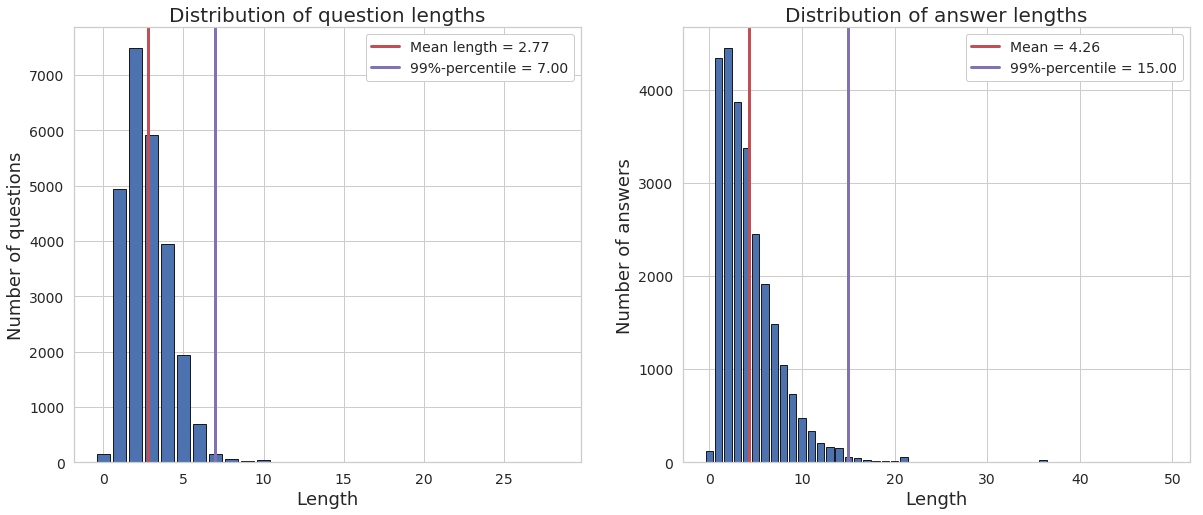

In [39]:
plt.figure(figsize=(20, 8))

plt.subplot(121)
plt.bar(*np.unique(question_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(question_lenghts), 
            c="r", lw=3, 
            label="Mean length = {:.2f}".format(np.mean(question_lenghts)))
plt.axvline(np.percentile(question_lenghts, 99), 
            c="m", lw=3, 
            label="99%-percentile = {:.2f}".format(np.percentile(question_lenghts, 99)))
plt.xlabel("Length")
plt.ylabel("Number of questions")
plt.title("Distribution of question lengths")
plt.legend()

plt.subplot(122)
plt.bar(*np.unique(answer_lenghts, return_counts=True), edgecolor="k")
plt.axvline(np.mean(answer_lenghts), 
            c="r", lw=3, 
            label="Mean = {:.2f}".format(np.mean(answer_lenghts)))
plt.axvline(np.percentile(answer_lenghts, 99), 
            c="m", lw=3, 
            label="99%-percentile = {:.2f}".format(np.percentile(answer_lenghts, 99)))
plt.xlabel("Length")
plt.ylabel("Number of answers")
plt.title("Distribution of answer lengths")
plt.legend();

In [40]:
cut_length = 7

In [41]:
questions_padded = pad_sequences(questions_tokenized, maxlen=cut_length)
answers_padded = pad_sequences(answers_tokenized, maxlen=cut_length)

In [43]:
q_train, q_valid = questions_padded[idxs_train], questions_padded[idxs_valid]
a_train, a_valid = answers_padded[idxs_train], answers_padded[idxs_valid]

In [44]:
print("Number of train pairs = {:d}".format(len(q_train)))
print("Number of valid pairs = {:d}".format(len(q_valid)))

Number of train pairs = 22869
Number of valid pairs = 2541


In [45]:
q_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="QInput")
a_input = Input(shape=(cut_length,), 
                dtype="int32", 
                name="AInput")

In [46]:
_embedding_layer = Embedding(input_dim=number_of_words + 1,
                             output_dim=200,
                             input_length=cut_length,
                             trainable=True,
                             mask_zero=True, 
                             name="Embedding")

In [47]:
q_embeddeding = _embedding_layer(q_input)
a_embeddeding = _embedding_layer(a_input)

In [48]:
q_rnn = LSTM(64, return_sequences=True, name="QLSTM")(q_embeddeding)
a_rnn = LSTM(64, return_sequences=True, name="ALSTM")(a_embeddeding)

In [50]:
class MaskedGlobalAveragePooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalAveragePooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalAveragePooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        if mask is not None:
            mask = K.cast(mask, 'float32')
            n = K.sum(mask, axis=-1, keepdims=True)
            n += K.ones_like(n) * K.cast(K.equal(n, 0.0), 'float32')
            ans = K.sum(x, axis=1) / n
        else:
            ans = K.mean(x, axis=1)
        
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

In [51]:
class MaskedGlobalMaxPooling1D(_GlobalPooling1D):
    
    def __init__(self, **kwargs):
        self.support_mask = True
        super(MaskedGlobalMaxPooling1D, self).__init__(**kwargs)
        
    def build(self, input_shape):
        super(MaskedGlobalMaxPooling1D, self).build(input_shape)
        self.feat_dim = input_shape[2]

    def call(self, x, mask=None):
        ans = K.max(x, axis=1)
        return ans

    def compute_mask(self, input_shape, input_mask=None):
        return None

In [52]:
q_max = MaskedGlobalMaxPooling1D(name="QGMP")(q_rnn)
a_max = MaskedGlobalMaxPooling1D(name="AGMP")(a_rnn)

In [53]:
def L2_norm(x):
    return K.l2_normalize(x, axis=1)

In [54]:
q_normalized = Lambda(function=L2_norm, name="QL2norm")(q_max)
a_normalized = Lambda(function=L2_norm, name="AL2norm")(a_max)

In [55]:
def triplet_loss(args):
    
    q, a = args
    
    def _get_probs():
        # easy negative sampling, i.e. take random from batch
        batch_size = tf.shape(a)[0]
        probs = tf.ones((batch_size, batch_size)) - tf.eye(batch_size, batch_size)
        return probs
    
    def _get_distance(batch1, batch2):
        return 1 - tf.reduce_sum(tf.multiply(batch1, batch2), axis=1)
    
    # margin
    alpha = 0.2
    
    # negative sampling
    probs = _get_probs()
    probs /= tf.reduce_sum(probs, axis=1)
    
    negative_idxs = tf.multinomial(tf.log(probs), 1)
    negs = tf.gather(a, negative_idxs)[:, 0]
    
    # distance calculation
    Dn = _get_distance(q, negs)
    Dp = _get_distance(q, a)
    
    # loss
    loss = tf.reduce_mean(tf.maximum(0.0, Dp - Dn + alpha))
    
    return loss

In [56]:
loss_layer = Lambda(function=triplet_loss, name="Loss")([q_normalized, a_normalized])

In [57]:
model = Model(inputs=[q_input, a_input], outputs=[loss_layer])

In [58]:
def dummy_loss(y_true, y_pred):
    return y_pred

In [59]:
model.compile(loss=dummy_loss, optimizer="Adam")

In [62]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
QInput (InputLayer)             (None, 7)            0                                            
__________________________________________________________________________________________________
AInput (InputLayer)             (None, 7)            0                                            
__________________________________________________________________________________________________
Embedding (Embedding)           (None, 7, 200)       3498400     QInput[0][0]                     
                                                                 AInput[0][0]                     
__________________________________________________________________________________________________
QLSTM (LSTM)                    (None, 7, 64)        67840       Embedding[0][0]                  
__________

In [63]:
hist = model.fit([q_train, a_train], np.zeros(q_train.shape[0]), 
                 validation_data=([q_valid, a_valid], np.zeros(q_valid.shape[0])), 
                 epochs=10, batch_size=128)


/home/alex/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22869 samples, validate on 2541 samples
Epoch 1/10
22869/22869 [==============================] - 21s 932us/step - loss: 0.1609 - val_loss: 0.1363
Epoch 2/10
22869/22869 [==============================] - 19s 840us/step - loss: 0.0721 - val_loss: 0.1227
Epoch 3/10
22869/22869 [==============================] - 20s 889us/step - loss: 0.0463 - val_loss: 0.1146
Epoch 4/10
22869/22869 [==============================] - 20s 887us/step - loss: 0.0348 - val_loss: 0.1072
Epoch 5/10
22869/22869 [==============================] - 19s 839us/step - loss: 0.0296 - val_loss: 0.1076
Epoch 6/10
22869/22869 [==============================] - 20s 876us/step - loss: 0.0253 - val_loss: 0.1062
Epoch 7/10
22869/22869 [==============================] - 20s 894us/step - loss: 0.0228 - val_loss: 0.1041
Epoch 8/10
22869/22869 [==============================] - 21s 929us/step - loss: 0.0214 - val_loss: 0.1037
Epoch 9/10
22869/22869 [==============================] - 21s 939us/step - loss: 0.0209 - val_l

In [64]:
model.save("./rnn.model")
pickle.dump(hist.history, open("./rnn.hist", "wb"))

In [68]:
model = load_model("./rnn.model", custom_objects={"MaskedGlobalMaxPooling1D": MaskedGlobalMaxPooling1D, 
                                                  "tf": tf, 
                                                  "dummy_loss": dummy_loss})
hist = pickle.load(open("./rnn.hist", "rb"))

/home/alex/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [69]:
q_model = Model(inputs=[model.get_layer("QInput").input], 
                outputs=[model.get_layer("QL2norm").output])
a_model = Model(inputs=[model.get_layer("AInput").input], 
                outputs=[model.get_layer("AL2norm").output])

In [95]:
class QAReplier(object):
    
    def __init__(self, tokenizer, q_model, a_model, **kwargs):
        """
        Constructor
        
        Args:
            tokenizer(keras.Tokenizer): fitted instance of Keras tokenizer class
            q_model(keras.Model):       question encoding tower of DSSM in the form of Keras model
            a_model(keras.Model):       answer encoding tower of DSSM in the form of Keras model
        
        Return:
            self
        """
        
        # call the ancestor constructor
        super(QAReplier, self).__init__(**kwargs)
        # assign passed parameters to the class fields
        self._tk = tokenizer
        self._q_model = q_model
        self._a_model = a_model
        
    def _preprocess(self, bank):
        """
        Preprocess the corpus of sentences into the suitable format
        to feed into the tower.
        
        Args:
            bank(np.ndarray): array of sentences to preprocess
            
        Return:
            bank_padded(np.ndarray): preprocessed and tokenized sentences
        """
        
        bank_processed = []
        # iterate over the corpus
        for i in range(len(bank)):
            # filter out specific symbols, punctuations, 
            # transform numbers into special <num> token, put everything to lower case
            q = " ".join([w if not w.isdigit() and not bool(re.search(r'[a-zA-Z]', w))
                          else "<num>" for w in text_to_word_sequence(bank[i])])
            bank_processed.append(q)
        bank_processed = np.array(bank_processed)
        
        # transform filtered sentences into sequences of tokens
        bank_tokenized = self._tk.texts_to_sequences(bank_processed)
        
        # pad sequences to the desired length (taken from the model input dimensions)
        bank_padded = pad_sequences(bank_tokenized, maxlen=self._q_model.layers[0].input_shape[1])
        
        return bank_padded
        
    def fit(self, answers_bank):
        """
        Fit the replier model to the predefined set of answers.
        All other answers will be chosen from the passed array.
        
        Args:
            answers_bank(np.ndarray): array of sentences from which 
                                      the model can answer

        Return:
            self
        """
        
        self._answers_bank = answers_bank
        # preprocess and then encode answers with the answer tower of DSMM
        _answers_bank_encoded = self._a_model.predict(self._preprocess(self._answers_bank))
        
        # nearest neighbors model to find the most suitable answer
        self._replier = NearestNeighbors(n_neighbors=5, 
                                         metric="minkowski", 
                                         p=2, 
                                         n_jobs=-1, 
                                         algorithm="kd_tree")
        # fir nearest neighbors model on the encoded set of answers
        self._replier.fit(_answers_bank_encoded)
        
        return self
    
    def answer(self, questions, n_answers=5):
        """
        Provide an answer to the given questions.
        
        Args:
            questions(str, list, np.ndarray): questions to the model
            n_answers(int):                   number of top answers to return
            
        Return:
            answers(np.ndarray): array of answers to the given questions
        """
        
        if type(questions) == str:
            questions = np.array([questions])
        elif type(questions) == list:
            questions = np.array(questions)
        elif type(questions) == np.ndarray:
            pass
        else:
            raise ValueError("Wrong format of question")
            
        questions = self._preprocess(questions)
            
        questions_encoded = self._q_model.predict(questions)
        
        res = self._replier.kneighbors(questions_encoded, n_neighbors=n_answers)[1]
        
        return self._answers_bank[res[0][0]],self._answers_bank[res[0][1]],self._answers_bank[res[0][2]]

In [96]:
replier = QAReplier(tk, q_model, a_model)

In [97]:
%%time
replier.fit(answers)

CPU times: user 9.16 s, sys: 363 ms, total: 9.53 s
Wall time: 4.89 s


In [114]:
replier.answer("никак")

('😌', '😌', 'Как совсем?')